In [7]:
import re
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
node = []
allDatas = []
siganlList = []
SignalsName = []
messageName = []

In [8]:
def readFile(file_name):
    global node,allDatas,siganlList,SignalsName,messageName
    ''' 得到dbc文件的绝对路径'''
    filePath = file_name
    if filePath:
        print(filePath)
        f = open(filePath, "r")  # 设置文件对象
    else:
        print("读取文件失败！")
        return 0
    """
    NodesPattern:节点
    MessagePattern：消息
    SignalPattern：信号
    """
    NodesPattern = re.compile(r"BU_: (.*)", re.S)
    MessagePattern = re.compile(r"BO_ (.*?) (.*?): (.*?) (.*)", re.S)
#     SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@.*? \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@([0-9])([+|-]) \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    DefaultValue = '''BA_ "GenSig(.*?)" SG_ (\d+) signalname (\d+);'''

    line = f.readline()
    allDatas=[]
    while line:
        """ 匹配出节点 """
        NodesSearched = re.search(NodesPattern, line.strip())
        if NodesSearched:
            node = NodesSearched.group(1).split(" ")
            #print(node)
        """ 匹配出消息 """
        MessageSearched = re.search(MessagePattern, line.strip())
        if MessageSearched:
            siganlList.clear()
            """如果匹配到了message，则获取到message的相关参数 
             比如匹配到了NM_Message_ESC_409，则会解析出改message的一些参数构成list对象['1033', 'NM_Message_ESC_409', '8', 'ESC']
             这四个参数分别是 messgage ID ;message name ; messgae dataLenth ,message sender
             而且把这个list对象 加在了 siganlList 索引0的位置
            """
            Message = list(MessageSearched.groups())
            siganlList.append(Message)
            """ 只 要 message的名字 messageName 列表中"""
            messageName.append(Message[1])
            """读取下一行"""
            line = f.readline()
            """因为有些message并没有定义signal，所以 下一行还是message"""
            MessageSearched = re.search(MessagePattern, line.strip())
            SignalSearched = re.search(SignalPattern, line.strip())
            """下一行如果不是message的内容 就一定是signal的内容了"""
            if not MessageSearched:
                while SignalSearched:
                    """获取信号的参数追加到siganlList"""
                    signal = list(SignalSearched.groups())
                    siganlList.append(signal)
                    """只获取 signal name"""
                    SignalsName.append(signal[0])

                    # 再次解析信号，直到这个message下的信号全部解析完毕
                    line = f.readline()
                    SignalSearched = re.search(SignalPattern, line.strip())
           # print(siganlList)
            c = copy.deepcopy(siganlList)
            allDatas.append(c)
        else:
            line = f.readline()
            MessageSearched = re.search(MessagePattern, line.strip())
    f.close()  # 将文件关闭
    return 1

In [9]:
import os
file_names = []
path = os.path.abspath('../My_DBC')
# path = os.path.abspath('./opendbc-master/opendbc-master')
dirs = os.listdir(path)                    # 获取指定路径下的文件
for i in dirs:
    if os.path.splitext(i)[1] == ".dbc":
        file_names.append(os.path.join(path,i))
file_names

['D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_object.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\gm_global_a_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_hatchback_ex_2017_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_sedan_16_diesel_2019_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_touring_2016_can_generated.dbc']

In [10]:
file_name = file_names[3]
file_name

'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_hatchback_ex_2017_can_generated.dbc'

In [11]:
readFile(file_name)

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_hatchback_ex_2017_can_generated.dbc


1

In [12]:
data_gts = {}
for alldata in allDatas:
#     print(str(hex(int(alldata[0][0]))))
#     print(str(hex(int(alldata[0][0])))[2:])
    data_gts[str(hex(int(alldata[0][0])))[2:]] = alldata

In [13]:
all_id_lsbs = {}
for k in data_gts.keys():
    message = data_gts[k]
    lsb_list = []
    series = np.zeros(64)
    message_id = message[0][0]+"_"+message[0][1]
    del message[0]
    for signal in message:
        start = int(signal[1])
        length = int(signal[2])
        endianness = int(signal[3])
        start_row = int(start / 8)
        start_col = 8 - (start - start_row * 8) - 1
        new_start = start_row * 8 + start_col
        if endianness == 0:
            new_end = new_start + length
            cur_lsb = new_end - 1
        if endianness == 1:
            cur_lsb = new_start
        lsb_list.append(cur_lsb)
    all_id_lsbs[k] = lsb_list
all_id_lsbs

{'94': [9, 39, 63, 59],
 'e4': [16, 23, 31, 15, 35, 39],
 'e5': [7, 15, 23, 31, 59, 63],
 'e8': [13, 47, 26, 51, 55],
 '14a': [15, 31, 37, 38, 39, 55, 59, 63],
 '158': [15, 31, 47, 55, 59, 63],
 '17c': [7, 31, 32, 33, 38, 39, 49, 50, 55, 59, 63],
 '18f': [15, 31, 35, 36, 47, 51, 55],
 '1a4': [27, 15, 41, 42, 59, 63],
 '1ab': [0, 15, 17, 19, 23],
 '1c2': [4, 27, 59, 63],
 '1d0': [14, 29, 44, 59, 63],
 '1df': [23, 18, 15, 34, 57, 37, 36, 35, 38, 40, 44, 59, 63],
 '1ea': [15, 31, 59, 63],
 '1ef': [31, 39, 23, 55, 15, 7, 0, 63, 59],
 '221': [16, 35, 43, 47],
 '240': [40, 46, 27, 11, 15, 59, 63],
 '241': [55, 10, 9, 27, 43, 3, 59, 63],
 '243': [40, 46, 27, 11, 15, 59, 63],
 '244': [55, 10, 9, 27, 43, 3, 59, 63],
 '246': [40, 46, 27, 11, 15, 59, 63],
 '247': [55, 10, 9, 27, 43, 3, 59, 63],
 '249': [40, 46, 27, 11, 15, 59, 63],
 '24a': [55, 10, 9, 27, 43, 3, 59, 63],
 '255': [7, 15, 23, 31, 39, 47, 55, 63, 59],
 '296': [2, 5, 27, 31],
 '305': [0, 13, 12, 11, 10, 9, 8, 51, 55],
 '309': [23, 15

In [14]:
all_id_labels = {}
for k in all_id_lsbs:
    cur_lsb_list = all_id_lsbs[k]
    cur_label = np.zeros(64)
    for cur_lsb in cur_lsb_list:
        cur_label[cur_lsb] = 1
    all_id_labels[k] = cur_label
all_id_labels

{'94': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'e4': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'e5': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'e8': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.

In [15]:
data = pd.read_csv('../../../DataMessage/Honda/honda001.csv')
data["bin"] = data["Data"].apply(int, base=16).apply(bin).str[2:].apply(lambda x: x.zfill(64))
group = data.groupby(by="ID")
id_tracelist = data["bin"].apply(lambda x: list(x)).tolist()
id_tracedict = {}
for trace in list(group):
    id_tracedict[trace[0]] = trace[1]["bin"].apply(lambda x: list(x)).tolist()

<BarContainer object of 64 artists>

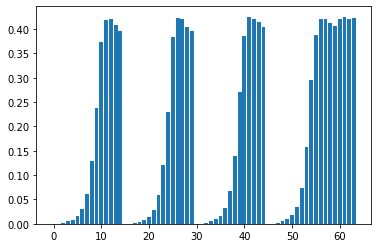

In [16]:
idname = '1d0'
messagelist = id_tracedict[idname]
trace_len = len(messagelist)
bit_flip = np.zeros(64)
previous = messagelist[0]
for item in messagelist:
    for ix in range(64):
        if item[ix] != previous[ix]:
            bit_flip[ix] = bit_flip[ix] + 1
    previous = item
for ix in range(64):
    bit_flip[ix] = bit_flip[ix] / trace_len
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip)), bit_flip)

### 1.获得大端数据，并计算大端的比特翻转率和比特翻转联合概率

In [ ]:
# 使用READ方法计算bit-flip
bit_flip_dict = {}
for id in id_tracedict.keys():
    messagelist = id_tracedict[id]
    trace_len = len(messagelist)
    bit_flips = []
    bit_flip = np.zeros(64)
    previous = messagelist[0]
    for i in range(trace_len):
        item = messagelist[i]
        for ix in range(64):
            if item[ix] != previous[ix]:
                bit_flip[ix] = bit_flip[ix] + 1
        previous = item
        for jx in range(64):
            bit_flip[jx] = bit_flip[jx] / (i+1)
            bit_flip = np.append(bit_flip, 0)
            bit_flip = np.append(bit_flip, 0)
        bit_flips.append(bit_flip)
    bit_flip_dict[id] = bit_flips
bit_flip_dict[idname]
# fig = plt.figure(facecolor = "white")
# plt.bar(range(len(bit_flip_dict[idname])), bit_flip_dict[idname])

In [ ]:
# 使用READ方法计算bit-flip
bit_flip_dict = {}
for id in id_tracedict.keys():
    messagelist = id_tracedict[id]
    trace_len = len(messagelist)
    bit_flip = np.zeros(64)
    previous = messagelist[0]
    for item in messagelist:
        for ix in range(64):
            if item[ix] != previous[ix]:
                bit_flip[ix] = bit_flip[ix] + 1
        previous = item
    for ix in range(64):
        bit_flip[ix] = bit_flip[ix] / trace_len
    
    bit_flip = np.append(bit_flip, 0)
    bit_flip = np.append(bit_flip, 0)
    
    bit_flip_dict[id] = bit_flip
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip_dict[idname])), bit_flip_dict[idname])

In [ ]:
bit_flip_list = []
for id in bit_flip_dict.keys():
    bit_flip_list.append(bit_flip_dict[id])

In [ ]:
bit_flip_list_df = pd.DataFrame(bit_flip_list)

In [ ]:
bit_flip_list_df

In [ ]:
# 测试honda001数据集中是否有翻转率为1的constant bit
for indexs in bit_flip_list_df.index:
    for i in range(len(bit_flip_list_df.loc[indexs].values)): 
        if(bit_flip_list_df.loc[indexs].values[i] == 1):
            print("indexs: "+str(indexs)+" i: " +str(i))
            print("values: "+str(bit_flip_list_df.loc[indexs].values[i])) 

1. 目前的问题：在honda001的数据集中，无法找到翻转率为1的constant bit，所以f-和c数据集都变得没有意义，且目前也无法检测这两个数据集下的情况。
2. 之后CAN-D方法将与深度学习方法比较，需要输入完整的bit数据集，且DL算法的目标是减少计算的复杂度，实现端到端，提高精度，
没有必要比较c数据集结果（也可以比较）。
3. 如果比较c数据集的结果，需要只学习无constant bit的数据集（可以提高ML的学习能力），得到无constant bit分类的结果，
再加上明显判断出的constant bit的边界结果，实现更精准的分类。

In [ ]:
# 使用READ方法计算bit-flip的联合概率
bit_flip_LH_dict = {}
bit_flip_LH_no_dict = {}
for id in id_tracedict.keys():
    messagelist = id_tracedict[id]
    bit_flip_LH = np.zeros(64)
    bit_flip_LH_no = np.zeros(64)
    previous_LH = messagelist[0]
    for item in messagelist:
        for ix in range(63):
            if item[ix] != previous_LH[ix] and item[ix+1] != previous_LH[ix+1]:
                bit_flip_LH[ix] = bit_flip_LH[ix] + 1
            if item[ix] == previous_LH[ix] and item[ix+1] == previous_LH[ix+1]:
                bit_flip_LH_no[ix] = bit_flip_LH_no[ix] + 1
        previous_LH = item
    for ix in range(63):
        bit_flip_LH[ix] = bit_flip_LH[ix] / trace_len
        bit_flip_LH_no[ix] = bit_flip_LH_no[ix] / trace_len
        
    bit_flip_LH = np.append(bit_flip_LH, 0)
    bit_flip_LH = np.append(bit_flip_LH, 0)
    bit_flip_LH_no = np.append(bit_flip_LH_no, 0)
    bit_flip_LH_no = np.append(bit_flip_LH_no, 0)

    bit_flip_LH_dict[id] = bit_flip_LH
    bit_flip_LH_no_dict[id] = bit_flip_LH_no
    
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip_LH_dict[idname])), bit_flip_LH_dict[idname])
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip_LH_no_dict[idname])), bit_flip_LH_no_dict[idname])

### 2.获得小端数据，并计算小端的比特翻转率和比特翻转联合概率

In [14]:
# reverse_id_tracelist
reverse_id_tracedict = {}
for id in id_tracedict.keys():
    id_tracelist = id_tracedict[id]
    reverse_id_tracelist = []
    for item in id_tracelist:
        cur_tracelist = [0,1,2,3,4,5,6,7]
        cur_temp = []
        count = 7
        for i in range(64):
            cur_temp.append(item[i])
            if (i+1)%8 == 0:
                cur_tracelist[count] = cur_temp
                count = count - 1
                cur_temp = []
        reverse_id_tracelist.append(np.concatenate(cur_tracelist).tolist())
    reverse_id_tracedict[id] = reverse_id_tracelist
reverse_id_tracedict[idname]

[['0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 ['0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 ['0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0

<BarContainer object of 66 artists>

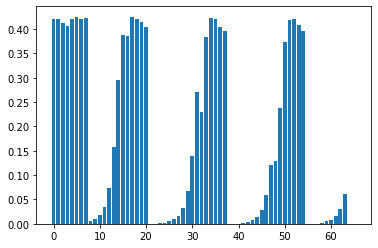

In [15]:
# 使用READ方法计算bit-flip
reverse_bit_flip_dict = {}
for id in reverse_id_tracedict.keys():
    reverse_messagelist = reverse_id_tracedict[id]
    reverse_trace_len = len(reverse_messagelist)
    reverse_bit_flip = np.zeros(64)
    reverse_previous = reverse_messagelist[0]
    for item in reverse_messagelist:
        for ix in range(64):
            if item[ix] != reverse_previous[ix]:
                reverse_bit_flip[ix] = reverse_bit_flip[ix] + 1
        reverse_previous = item
    for ix in range(64):
        reverse_bit_flip[ix] = reverse_bit_flip[ix] / reverse_trace_len
    
    reverse_bit_flip = np.append(reverse_bit_flip, 0)
    reverse_bit_flip = np.append(reverse_bit_flip, 0)
    
    reverse_bit_flip_dict[id] = reverse_bit_flip
fig = plt.figure(facecolor = "white")
plt.bar(range(len(reverse_bit_flip_dict[idname])), reverse_bit_flip_dict[idname])

<BarContainer object of 66 artists>

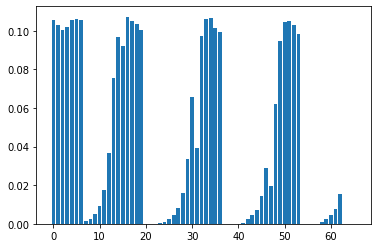

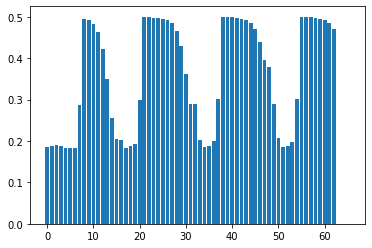

In [16]:
# 使用READ方法计算bit-flip的联合概率
reverse_bit_flip_LH_dict = {}
reverse_bit_flip_LH_no_dict = {}
for id in reverse_id_tracedict.keys():
    reverse_messagelist = reverse_id_tracedict[id]
    reverse_bit_flip_LH = np.zeros(64)
    reverse_bit_flip_LH_no = np.zeros(64)
    reverse_previous_LH = reverse_messagelist[0]
    for item in reverse_messagelist:
        for ix in range(63):
            if item[ix] != reverse_previous_LH[ix] and item[ix+1] != reverse_previous_LH[ix+1]:
                reverse_bit_flip_LH[ix] = reverse_bit_flip_LH[ix] + 1
            if item[ix] == reverse_previous_LH[ix] and item[ix+1] == reverse_previous_LH[ix+1]:
                reverse_bit_flip_LH_no[ix] = reverse_bit_flip_LH_no[ix] + 1
        reverse_previous_LH = item
    for ix in range(63):
        reverse_bit_flip_LH[ix] = reverse_bit_flip_LH[ix] / trace_len
        reverse_bit_flip_LH_no[ix] = reverse_bit_flip_LH_no[ix] / trace_len
        
    reverse_bit_flip_LH = np.append(reverse_bit_flip_LH, 0)
    reverse_bit_flip_LH = np.append(reverse_bit_flip_LH, 0)
    reverse_bit_flip_LH_no = np.append(reverse_bit_flip_LH_no, 0)
    reverse_bit_flip_LH_no = np.append(reverse_bit_flip_LH_no, 0)

    reverse_bit_flip_LH_dict[id] = reverse_bit_flip_LH
    reverse_bit_flip_LH_no_dict[id] = reverse_bit_flip_LH_no
    
fig = plt.figure(facecolor = "white")
plt.bar(range(len(reverse_bit_flip_LH_dict[idname])), reverse_bit_flip_LH_dict[idname])
fig = plt.figure(facecolor = "white")
plt.bar(range(len(reverse_bit_flip_LH_no_dict[idname])), reverse_bit_flip_LH_no_dict[idname])

<BarContainer object of 64 artists>

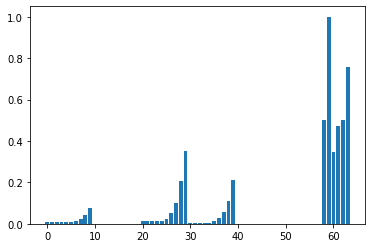

In [17]:
# 小端转成大端的正常格式，方便与上边生成的ground truth label匹配
reverse_id_tracelist = []
item = reverse_bit_flip
cur_tracelist = [0,1,2,3,4,5,6,7]
cur_temp = []
count = 7
for i in range(64):
    cur_temp.append(item[i])
    if (i+1)%8 == 0:
        cur_tracelist[count] = cur_temp
        count = count - 1
        cur_temp = []
fig = plt.figure(facecolor = "white")
plt.bar(range(len(np.concatenate(cur_tracelist).tolist())), np.concatenate(cur_tracelist).tolist())

### 3.先不去掉常数位，实现CAN-D

In [18]:
def get_reverse_sub_feature(ix, id):
    f1 = reverse_bit_flip_dict[id][ix]
    f2 = reverse_bit_flip_LH_dict[id][ix] / reverse_bit_flip_dict[id][ix+1]
    f3 = reverse_bit_flip_LH_dict[id][ix] / reverse_bit_flip_dict[id][ix]
    f4 = reverse_bit_flip_LH_no_dict[id][ix] / (1 - reverse_bit_flip_dict[id][ix+1])
    f5 = reverse_bit_flip_LH_no_dict[id][ix] / (1 - reverse_bit_flip_dict[id][ix])
    return np.array([f1,f2,f3,f4,f5])

def get_sub_feature(ix, id):
    f1 = bit_flip_dict[id][ix]
    f2 = bit_flip_LH_dict[id][ix] / bit_flip_dict[id][ix+1]
    f3 = bit_flip_LH_dict[id][ix] / bit_flip_dict[id][ix]
    f4 = bit_flip_LH_no_dict[id][ix] / (1 - bit_flip_dict[id][ix+1])
    f5 = bit_flip_LH_no_dict[id][ix] / (1 - bit_flip_dict[id][ix])
    return np.array([f1,f2,f3,f4,f5])

In [19]:
def get_reverse_feature(ix, id):
    reverse_cur_bit_feature = []
    reverse_feature_sub1 = get_reverse_sub_feature(ix, id)
    reverse_feature_sub2 = get_reverse_sub_feature(ix+1, id)
    reverse_feature_sub3 = reverse_feature_sub2 - reverse_feature_sub1
    return np.concatenate((reverse_feature_sub1,reverse_feature_sub2,reverse_feature_sub3))

def get_feature(ix, id):
    cur_bit_feature = []
    feature_sub1 = get_sub_feature(ix, id)
    feature_sub2 = get_sub_feature(ix+1, id)
    feature_sub3 = feature_sub2 - feature_sub1
    return np.concatenate((feature_sub1,feature_sub2,feature_sub3))

In [20]:
# 小端
reverse_bit_features_dict = {}
for id in reverse_bit_flip_dict.keys():
    reverse_bit_features = []
    for ix in range(64):
        reverse_bit_features.append(get_reverse_feature(ix, id))
    reverse_bit_features_dict[id] = reverse_bit_features
reverse_bit_features_dict[idname]

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


[array([ 4.21359264e-01,  2.50339759e-01,  2.50062849e-01,  3.18145235e-01,
         3.18401494e-01,  4.20893182e-01,  2.50746345e-01,  2.45205617e-01,
         3.17743213e-01,  3.22846168e-01, -4.66081946e-04,  4.06586081e-04,
        -4.85723146e-03, -4.02021970e-04,  4.44467412e-03]),
 array([ 0.42089318,  0.25074635,  0.24520562,  0.31774321,  0.32284617,
         0.41159273,  0.2473432 ,  0.24438954,  0.32268085,  0.32537625,
        -0.00930045, -0.00340315, -0.00081608,  0.00493764,  0.00253008]),
 array([ 0.41159273,  0.2473432 ,  0.24438954,  0.32268085,  0.32537625,
         0.40667768,  0.24208463,  0.2509377 ,  0.32489745,  0.31675355,
        -0.00491505, -0.00525856,  0.00654815,  0.0022166 , -0.0086227 ]),
 array([ 0.40667768,  0.24208463,  0.2509377 ,  0.32489745,  0.31675355,
         0.42154993,  0.24880204,  0.25050256,  0.31726664,  0.31568635,
         0.01487225,  0.0067174 , -0.00043513, -0.00763081, -0.00106721]),
 array([ 0.42154993,  0.24880204,  0.25050256,  

In [21]:
# 小端转成大端的正常格式，方便与上边生成的ground truth label匹配
bit_features_dict = {}
for id in reverse_bit_features_dict.keys():
    item = reverse_bit_features_dict[id]
    cur_bit_features = [0,1,2,3,4,5,6,7]
    cur_temp = []
    count = 7
    for i in range(64):
        cur_temp.append(item[i])
        if (i+1)%8 == 0:
            cur_bit_features[count] = cur_temp
            count = count - 1
            cur_temp = []
    bit_features_dict[id] = np.concatenate(cur_bit_features).tolist()
bit_features_dict[idname]

[[0.0,
  0.0,
  nan,
  0.5,
  0.49998940722850727,
  2.1185542985466717e-05,
  0.004761904761904762,
  0.5,
  0.5,
  0.49889832842524523,
  2.1185542985466717e-05,
  0.004761904761904762,
  nan,
  0.0,
  -0.0010910788032620355],
 [2.1185542985466717e-05,
  0.004761904761904762,
  0.5,
  0.5,
  0.49889832842524523,
  0.002224482013474005,
  0.23437499999999997,
  0.5,
  0.5,
  0.4987366498927745,
  0.0022032964704885383,
  0.2296130952380952,
  0.0,
  0.0,
  -0.0001616785324707326],
 [0.002224482013474005,
  0.23437499999999997,
  0.5,
  0.5,
  0.4987366498927745,
  0.004745561628744545,
  0.2731707317073171,
  0.5,
  0.5,
  0.49802034995104094,
  0.0025210796152705397,
  0.03879573170731712,
  0.0,
  0.0,
  -0.0007162999417335558],
 [0.004745561628744545,
  0.2731707317073171,
  0.5,
  0.5,
  0.49802034995104094,
  0.008686072624041355,
  0.27891156462585037,
  0.5,
  0.5,
  0.49652718413403996,
  0.00394051099529681,
  0.0057408329185332785,
  0.0,
  0.0,
  -0.0014931658170009854],
 [

In [22]:
# 大端
bit_features_dict = {}
for id in bit_flip_dict.keys():
    bit_features = []
    for ix in range(64):
        bit_features.append(get_feature(ix, id))
    bit_features_dict[id] = bit_features
bit_features_dict[idname]

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


[array([ 0.00000000e+00,  0.00000000e+00,             nan,  5.00000000e-01,
         4.99989407e-01,  2.11855430e-05,  4.76190476e-03,  5.00000000e-01,
         5.00000000e-01,  4.98898328e-01,  2.11855430e-05,  4.76190476e-03,
                    nan,  0.00000000e+00, -1.09107880e-03]),
 array([ 2.11855430e-05,  4.76190476e-03,  5.00000000e-01,  5.00000000e-01,
         4.98898328e-01,  2.22448201e-03,  2.34375000e-01,  5.00000000e-01,
         5.00000000e-01,  4.98736650e-01,  2.20329647e-03,  2.29613095e-01,
         0.00000000e+00,  0.00000000e+00, -1.61678532e-04]),
 array([ 0.00222448,  0.234375  ,  0.5       ,  0.5       ,  0.49873665,
         0.00474556,  0.27317073,  0.5       ,  0.5       ,  0.49802035,
         0.00252108,  0.03879573,  0.        ,  0.        , -0.0007163 ]),
 array([ 0.00474556,  0.27317073,  0.5       ,  0.5       ,  0.49802035,
         0.00868607,  0.27891156,  0.5       ,  0.5       ,  0.49652718,
         0.00394051,  0.00574083,  0.        ,  0.     

In [23]:
alldatas_lsb = []
alllabels_lsb = []
for id in reverse_bit_features_dict.keys():
    if(reverse_bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
        cur_features = reverse_bit_features_dict[id]
        cur_labels = all_id_labels[id]
        for i in range(64):
            alldatas_lsb.append(cur_features[i])
            alllabels_lsb.append(int(cur_labels[i]))
    else:
        print(id)

13c
156
161
18e
19b
1a6
1aa
1dc
1ed
21e
294
295
320
328
372
377
378
386
39
3d7
3d9
400
403
406
40c
40f
428
42d
42e
454
465
555
91


In [24]:
alldatas_msb = []
alllabels_msb = []
for id in bit_features_dict.keys():
    if(bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
        cur_features = bit_features_dict[id]
        cur_labels = all_id_labels[id]
        for i in range(64):
            alldatas_msb.append(cur_features[i])
            alllabels_msb.append(int(cur_labels[i]))
    else:
        print(id)

13c
156
161
18e
19b
1a6
1aa
1dc
1ed
21e
294
295
320
328
372
377
378
386
39
3d7
3d9
400
403
406
40c
40f
428
42d
42e
454
465
555
91


In [25]:
for id in reverse_bit_features_dict.keys():
    if all_id_labels.__contains__(id):
        print(id)

158
17c
191
1a4
1b0
1d0
1ea
221
255
305
309
324
374
405


#### 训练模型

In [26]:
ALLdata_lsb = pd.DataFrame(alldatas_lsb)
ALLdata_lsb['label'] = np.array(alllabels_lsb)
ALLdata_lsb

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,0.000000,NaN,NaN,1.000032,1.000032,0.000000,0.000000,NaN,1.000032,0.500021,0.000000,NaN,NaN,2.220446e-16,-0.500011,0
1,0.000000,0.000000,NaN,1.000032,0.500021,0.499995,0.500016,1.000032,1.000032,0.000021,0.499995,0.500016,NaN,1.143974e-12,-0.500000,0
2,0.499995,0.500016,1.000032,1.000032,0.000021,0.999989,1.000032,0.456341,0.000019,1.000032,0.499995,0.500016,-0.543690,-1.000012e+00,1.000011,0
3,0.999989,1.000032,0.456341,0.000019,1.000032,0.456322,0.496459,0.542752,0.583637,0.537960,-0.543667,-0.503572,0.086410,5.836177e-01,-0.462072,0
4,0.456322,0.496459,0.542752,0.583637,0.537960,0.498872,0.517898,0.517799,0.520061,0.520160,0.042550,0.021439,-0.024953,-6.357590e-02,-0.017800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,0.000000,NaN,NaN,0.033325,0.033325,0.000000,NaN,NaN,0.033325,0.033325,0.000000,NaN,NaN,0.000000e+00,0.000000,1
892,0.000000,NaN,NaN,0.033325,0.033325,0.000000,NaN,NaN,0.033325,0.033325,0.000000,NaN,NaN,0.000000e+00,0.000000,0
893,0.000000,NaN,NaN,0.033325,0.033325,0.000000,NaN,NaN,0.033325,0.033325,0.000000,NaN,NaN,0.000000e+00,0.000000,0
894,0.000000,NaN,NaN,0.033325,0.033325,0.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,-3.332486e-02,-0.033325,0


In [27]:
ALLdata_msb = pd.DataFrame(alldatas_msb)
ALLdata_msb['label'] = np.array(alllabels_msb)
ALLdata_msb

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,0.000000,NaN,NaN,1.000032,1.000032,0.000000,0.000000,NaN,1.000032,1.000000,0.000000,NaN,NaN,0.000000e+00,-0.000032,0
1,0.000000,0.000000,NaN,1.000032,1.000000,0.000032,0.076926,1.000032,1.000032,0.999650,0.000032,0.076926,NaN,0.000000e+00,-0.000350,0
2,0.000032,0.076926,1.000032,1.000032,0.999650,0.000413,0.336218,1.000032,1.000032,0.999216,0.000381,0.259292,-2.220446e-16,2.220446e-16,-0.000435,0
3,0.000413,0.336218,1.000032,1.000032,0.999216,0.001229,0.394570,1.000032,1.000032,0.998144,0.000816,0.058353,0.000000e+00,-2.220446e-16,-0.001072,0
4,0.001229,0.394570,1.000032,1.000032,0.998144,0.003114,0.504304,1.000032,1.000032,0.996961,0.001885,0.109734,0.000000e+00,2.220446e-16,-0.001183,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,0.999682,0.033325,0.000456,0.000011,0.033325,0.013668,0.000912,0.033325,0.033325,0.016904,-0.986014,-0.032413,3.286923e-02,3.331412e-02,-0.016421,1
892,0.013668,0.000912,0.033325,0.033325,0.016904,0.499682,0.016641,0.016641,0.016662,0.016662,0.486014,0.015730,-1.668363e-02,-1.666243e-02,-0.000242,0
893,0.499682,0.016641,0.016641,0.016662,0.016662,0.499682,0.016657,0.033325,0.033325,0.000021,0.000000,0.000016,1.668363e-02,1.666243e-02,-0.016641,0
894,0.499682,0.016657,0.033325,0.033325,0.000021,0.999682,NaN,0.000000,0.000000,0.000000,0.500000,NaN,-3.332486e-02,-3.332486e-02,-0.000021,0


In [28]:
# #随机森林方法
# import joblib
# #RF模型加载
# model = joblib.load('./Model/rf_constant_bit_f+_fillna0_2022_3_7.pkl')

In [29]:
ALLdata_lsb = ALLdata_lsb.fillna(0)
x_lsb = ALLdata_lsb.iloc[:,:15]
y_lsb = ALLdata_lsb.iloc[:,-1]
y_lsb = pd.DataFrame(y_lsb.tolist())

#划分训练集测试集，取10%的测试集。
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
kf = KFold(n_splits=5)
for train_index,test_index in kf.split(x_lsb):
    print('train_index', train_index, 'test_index', test_index)
    train_data, train_labels = x_lsb.iloc[train_index], y_lsb.iloc[train_index]
    test_data, test_labels = x_lsb.iloc[test_index], y_lsb.iloc[test_index]
    
train_labels = np.array(train_labels.T)[0]
test_labels = np.array(test_labels.T)[0]

#随机森林方法
from sklearn.ensemble import RandomForestClassifier
model_lsb = RandomForestClassifier(n_estimators= 30)
model_lsb.fit(train_data,train_labels)

print("训练集:")
predict_target_lsb = model_lsb.predict(train_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_lsb == train_labels),len(train_labels))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels,predict_target_lsb))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels,predict_target_lsb))

print("测试集:")
predict_target_test_lsb = model_lsb.predict(test_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_lsb == test_labels),len(test_labels))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels,predict_target_test_lsb))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels,predict_target_test_lsb))

train_index [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 42

训练集:
预测正确数量,训练集样本量:
687 717
训练集精确度等指标：
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       644
           1       0.98      0.60      0.75        73

    accuracy                           0.96       717
   macro avg       0.97      0.80      0.86       717
weighted avg       0.96      0.96      0.95       717

混淆矩阵：
[[643   1]
 [ 29  44]]
测试集:
预测正确数量,训练集样本量:
163 179
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       162
           1       1.00      0.06      0.11        17

    accuracy                           0.91       179
   macro avg       0.96      0.53      0.53       179
weighted avg       0.92      0.91      0.87       179

混淆矩阵：
[[162   0]
 [ 16   1]]


In [30]:
ALLdata_msb = ALLdata_msb.fillna(0)
x_msb = ALLdata_msb.iloc[:,:15]
y_msb = ALLdata_msb.iloc[:,-1]
y_msb = pd.DataFrame(y_msb.tolist())

#划分训练集测试集，取10%的测试集。
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
kf = KFold(n_splits=5)
for train_index,test_index in kf.split(x_msb):
    print('train_index', train_index, 'test_index', test_index)
    train_data, train_labels = x_msb.iloc[train_index], y_msb.iloc[train_index]
    test_data, test_labels = x_msb.iloc[test_index], y_msb.iloc[test_index]
    
train_labels = np.array(train_labels.T)[0]
test_labels = np.array(test_labels.T)[0]

#随机森林方法
from sklearn.ensemble import RandomForestClassifier
model_msb = RandomForestClassifier(n_estimators= 30)
model_msb.fit(train_data,train_labels)

print("训练集:")
predict_target_msb = model_msb.predict(train_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb == train_labels),len(train_labels))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels,predict_target_msb))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels,predict_target_msb))

print("测试集:")
predict_target_test_msb =model_msb.predict(test_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb == test_labels),len(test_labels))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels,predict_target_test_msb))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels,predict_target_test_msb))

train_index [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 42

训练集:
预测正确数量,训练集样本量:
688 717
训练集精确度等指标：
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       644
           1       0.96      0.63      0.76        73

    accuracy                           0.96       717
   macro avg       0.96      0.81      0.87       717
weighted avg       0.96      0.96      0.96       717

混淆矩阵：
[[642   2]
 [ 27  46]]
测试集:
预测正确数量,训练集样本量:
162 179
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       162
           1       0.50      0.29      0.37        17

    accuracy                           0.91       179
   macro avg       0.71      0.63      0.66       179
weighted avg       0.89      0.91      0.89       179

混淆矩阵：
[[157   5]
 [ 12   5]]


### 4.实现Endianness优化算法，没有考虑Constant bit，针对id=1d0

In [31]:
idname = '1d0'

In [32]:
alldatas_msb_idname = []
alllabels_msb_idname = []
id = idname
if(bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
    cur_features = bit_features_dict[id]
    cur_labels = all_id_labels[id]
    for i in range(64):
        alldatas_msb_idname.append(cur_features[i])
        alllabels_msb_idname.append(int(cur_labels[i]))
else:
    print(id)
ALLdata_msb_idname = pd.DataFrame(alldatas_msb_idname)
ALLdata_msb_idname['label'] = np.array(alllabels_msb_idname)
ALLdata_msb_idname = ALLdata_msb_idname.fillna(0)
x_msb_idname = ALLdata_msb_idname.iloc[:,:15]
y_msb_idname = ALLdata_msb_idname.iloc[:,-1]
# y_msb_idname = pd.DataFrame(y_msb_idname.tolist())

In [33]:
alldatas_lsb_idname = []
alllabels_lsb_idname = []
id = idname
if(reverse_bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
    cur_features = reverse_bit_features_dict[id]
    cur_labels = all_id_labels[id]
    for i in range(64):
        alldatas_lsb_idname.append(cur_features[i])
        alllabels_lsb_idname.append(int(cur_labels[i]))
else:
    print(id)
ALLdata_lsb_idname = pd.DataFrame(alldatas_lsb_idname)
ALLdata_lsb_idname['label'] = np.array(alllabels_lsb_idname)
ALLdata_lsb_idname = ALLdata_lsb_idname.fillna(0)
x_lsb_idname = ALLdata_lsb_idname.iloc[:,:15]
y_lsb_idname = ALLdata_lsb_idname.iloc[:,-1]
# y_lsb_idname = pd.DataFrame(y_lsb_idname.tolist())

In [34]:
predict_msb = model_msb.predict(x_msb_idname)
predict_proba_msb = model_msb.predict_proba(x_msb_idname)
predict_proba_msb

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.

In [35]:
predict_lsb = model_lsb.predict(x_lsb_idname)
predict_proba_lsb = model_lsb.predict_proba(x_lsb_idname)
predict_proba_lsb

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.86666667, 0.13333333],
       [0.93333333, 0.06666667],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.83333333, 0.16666667],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.93333333, 0.06666667],
       [0.96666667, 0.03333333],
       [0.93333333, 0.06666667],
       [0.9       , 0.1       ],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [0.33333333, 0.66666667],
       [1.

In [36]:
predict_msb

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
      dtype=int64)

In [37]:
predict_lsb

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [38]:
predictproba_lsb = []
for prediction in predict_proba_lsb:
    predictproba_lsb.append(prediction[1])
    
predictproba_msb = []
for prediction in predict_proba_msb:
    predictproba_msb.append(prediction[1])

In [39]:
ResP = pd.DataFrame(predictproba_lsb, columns=['LsbP'])
ResP['MsbP'] = predictproba_msb
ResP['label'] = y_lsb
ResP

,LsbP,MsbP,label
0,0.000000,0.000000,0
1,0.000000,0.000000,0
2,0.033333,0.000000,0
3,0.033333,0.000000,0
4,0.000000,0.000000,0
...,...,...,...
59,0.400000,0.600000,1
60,0.000000,0.066667,0
61,0.100000,0.000000,0
62,0.000000,0.033333,0


In [40]:
B = 0.6
def get_signals(predictprobas):
    signals = []
    cur_signal = []
    for lsb in predictprobas:
        cur_signal.append(lsb)
        if lsb >= B:
            signals.append(cur_signal)
            cur_signal = []
    return signals

In [41]:
lsb_signals = get_signals(predictproba_lsb)
msb_signals = get_signals(predictproba_msb)

In [42]:
pd.DataFrame(lsb_signals)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.000000,0.033333,0.033333,0.0,0.0,0.0,0.133333,0.066667,0.000000,...,0.066667,0.100000,0.033333,0.033333,0.000000,0.666667,NaN,NaN,NaN,NaN
1,0.0,0.066667,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.021212,0.066667,...,0.000000,0.084047,0.000000,0.000000,0.033333,0.400000,0.0,0.1,0.0,1.0


In [43]:
pd.DataFrame(msb_signals)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.033333,0.033333,1.0
1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.033333,0.000000,1.0
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.6
4,0.066667,0.0,0.033333,0.933333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
V = []
setlist1 = ['JB', 'C']
setlist2 = ['JB', 'JL', 'C']
setlist3 = ['JL', 'C']
flag = True
count = 0
for a in setlist1:
    for b in setlist2:
        for c in setlist2:
            for d in setlist2:
                for e in setlist2:
                    for f in setlist2:
                        for g in setlist2:
                            for h in setlist3:
                                v = [a,b,c,d,e,f,g,h]
                                for i in range(8):
                                    if(v[i] == 'JB' and v[i+1] == 'JL'):
                                        flag = False
                                        break
                                    if(v[i] == 'JB' and i<6 and v[i+2] == 'JL'):
                                        flag = False
                                        break
                                if flag == True:
                                    V.append(v)
                                    count = count + 1
                                flag = True

In [49]:
len(V), V

(577,
 [['JB', 'JB', 'JB', 'JB', 'JB', 'JB', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'JB', 'JB', 'C', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'JB', 'C', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'JB', 'C', 'C', 'JL'],
  ['JB', 'JB', 'JB', 'JB', 'JB', 'C', 'C', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'JB', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'JB', 'C', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'C', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'C', 'JL', 'JL'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'C', 'JL', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'C', 'C', 'JL'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'C', 'C', 'C'],
  ['JB', 'JB', 'JB', 'C', 'JB', 'JB', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'C', 'JB', 'JB', 'C', 'C'],
  ['JB', 'JB', 'JB', 'C', 'JB', 'C', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'C', 'JB', 'C', 'C', 'JL'],
  ['JB', 'JB', 'JB', 'C', 'JB', 'C', 'C', 'C'],
  ['JB', 'JB', 'JB', 'C', 'C', 'JB', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'C', 'C', 'JB', 'C', 'C'],
  ['JB', 'JB', 'JB', 'C', 'C', 'JL', 'JB', 'C'],
  ['JB', 

In [54]:
E = []
for v in V:
    e = ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
    for i in range(8):
        if v[i] == 'JB':
            e[i] = 'B'
            e[i+1] = 'B'
        if v[i] == 'JL':
            e[i] = 'L'
            e[i-1] = 'L'
    E.append(e)

In [69]:
E

[['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'L', 'L'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'C', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'C', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'L', 'L', 'L'],
 ['B', 'B', 'B', 'B', 'B', 'L', 'L', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'C', 'L', 'L'],
 ['B', 'B', 'B', 'B', 'B', 'C', 'C', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'L', 'L'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'C', 'C'],
 ['B', 'B', 'B', 'B', 'C', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'C', 'B', 'B', 'C'],
 ['B', 'B', 'B', 'B', 'L', 'L', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'L', 'L', 'L', 'L'],
 ['B', 'B', 'B', 'B', 'L', 'L', 'L', 'C'],
 ['B', 'B', 'B', 'B', 'L', 'L', 'L', 'L'],
 ['B', 'B',

In [81]:
EB = pd.DataFrame(E).replace('C', 'B')
EB = np.array(EB).tolist()

In [82]:
EL = pd.DataFrame(E).replace('C', 'L')
EL = np.array(EL).tolist()

In [110]:
# 得到所有可能的信号标记集合T
def get_T(proba_msb, proba_lsb):
    T = []
    for e in EB:
        t = []
        for i in range(8):
            if e[i] == 'B':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_msb[j])
            if e[i] == 'L':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_lsb[j])
        T.append(t)
    for e in EL:
        t = []
        for i in range(8):
            if e[i] == 'B':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_msb[j])
            if e[i] == 'L':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_lsb[j])
        T.append(t)
    return T

In [111]:
T = get_T(predictproba_msb, predictproba_lsb)
B = 0.6
mint0 = []
for t in T:
    t0 = 0
    for f in t:
        t0 = t0 + min(f, B)
    mint0.append(t0)

In [112]:
tf = pd.DataFrame(T)
tf['t0'] = mint0
tf

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,t0
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.033333,0.0,0.0,0.000000,0.6,0.066667,0.0,0.033333,0.933333,3.300000
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.033333,0.0,0.0,0.000000,0.6,0.066667,0.0,0.033333,0.933333,3.300000
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.033333,0.0,0.0,0.000000,0.6,0.066667,0.0,0.033333,0.933333,3.300000
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.084047,0.0,0.0,0.033333,0.4,0.000000,0.1,0.000000,1.000000,3.150714
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.033333,0.0,0.0,0.000000,0.6,0.066667,0.0,0.033333,0.933333,3.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.133333,0.066667,0.0,...,0.033333,0.0,0.0,0.000000,0.6,0.066667,0.0,0.033333,0.933333,4.307879
1150,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.133333,0.066667,0.0,...,0.084047,0.0,0.0,0.033333,0.4,0.000000,0.1,0.000000,1.000000,4.158593
1151,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.133333,0.066667,0.0,...,0.084047,0.0,0.0,0.033333,0.4,0.000000,0.1,0.000000,1.000000,4.158593
1152,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.133333,0.066667,0.0,...,0.084047,0.0,0.0,0.033333,0.4,0.000000,0.1,0.000000,1.000000,4.158593


In [113]:
res = tf[tf['t0'] == min(mint0)]
res

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,t0
578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333


In [114]:
final_res = res.drop_duplicates()
final_res

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,t0
578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333


In [115]:
final_t = np.array(final_res)[0][:-1]
final_t

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03333333, 0.03333333, 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03333333, 0.        , 0.03333333, 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03333333, 0.        , 0.        ,
       0.03333333, 0.        , 0.        , 0.03333333, 0.4       ,
       0.        , 0.1       , 0.        , 1.        ])

In [116]:
final_label = []
for i in range(64):
    if final_t[i] >= B:
        final_label.append(i)
final_label

[14, 29, 44, 63]

In [117]:
all_id_lsbs['1d0']

[14, 29, 44, 59, 63]

### 5.实现Endianness优化算法，没有考虑Constant bit

In [ ]:
alldatas_msb_idname = []
alllabels_msb_idname = []
id = idname
if(bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
    cur_features = bit_features_dict[id]
    cur_labels = all_id_labels[id]
    for i in range(64):
        alldatas_msb_idname.append(cur_features[i])
        alllabels_msb_idname.append(int(cur_labels[i]))
else:
    print(id)
ALLdata_msb_idname = pd.DataFrame(alldatas_msb_idname)
ALLdata_msb_idname['label'] = np.array(alllabels_msb_idname)
ALLdata_msb_idname = ALLdata_msb_idname.fillna(0)
x_msb_idname = ALLdata_msb_idname.iloc[:,:15]
y_msb_idname = ALLdata_msb_idname.iloc[:,-1]

In [ ]:
alldatas_lsb_idname = []
alllabels_lsb_idname = []
id = idname
if(reverse_bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
    cur_features = reverse_bit_features_dict[id]
    cur_labels = all_id_labels[id]
    for i in range(64):
        alldatas_lsb_idname.append(cur_features[i])
        alllabels_lsb_idname.append(int(cur_labels[i]))
else:
    print(id)
ALLdata_lsb_idname = pd.DataFrame(alldatas_lsb_idname)
ALLdata_lsb_idname['label'] = np.array(alllabels_lsb_idname)
ALLdata_lsb_idname = ALLdata_lsb_idname.fillna(0)
x_lsb_idname = ALLdata_lsb_idname.iloc[:,:15]
y_lsb_idname = ALLdata_lsb_idname.iloc[:,-1]
# y_lsb_idname = pd.DataFrame(y_lsb_idname.tolist())

In [120]:
alldatas_msb_dict = {}
# alllabels_msb_dict = {}
# cur_alldatas_msb = []
# cur_alllabels_msb = []
for id in bit_features_dict.keys():
    if(bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
        cur_features = bit_features_dict[id]
#         cur_labels = all_id_labels[id]
#         for i in range(64):
#             cur_alldatas_msb.append(cur_features[i])
# #             cur_alllabels_msb.append(int(cur_labels[i]))
    else:
        print(id)
    cur_features = pd.DataFrame(cur_features).fillna(0)
    alldatas_msb_dict[id] = cur_features

13c
156
161
18e
19b
1a6
1aa
1dc
1ed
21e
294
295
320
328
372
377
378
386
39
3d7
3d9
400
403
406
40c
40f
428
42d
42e
454
465
555
91


In [121]:
alldatas_lsb_dict = {}
# alllabels_msb_dict = {}
# cur_alldatas_msb = []
# cur_alllabels_msb = []
for id in bit_features_dict.keys():
    if(reverse_bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
        cur_features = reverse_bit_features_dict[id]
#         cur_labels = all_id_labels[id]
#         for i in range(64):
#             cur_alldatas_msb.append(cur_features[i])
#             cur_alllabels_msb.append(int(cur_labels[i]))
    else:
        print(id)
    cur_features = pd.DataFrame(cur_features).fillna(0)
    alldatas_lsb_dict[id] = cur_features

13c
156
161
18e
19b
1a6
1aa
1dc
1ed
21e
294
295
320
328
372
377
378
386
39
3d7
3d9
400
403
406
40c
40f
428
42d
42e
454
465
555
91


In [130]:
predict_proba_msb_dict = {}
for id in alldatas_msb_dict.keys():
    cur_predictproba_msb = []
    cur_predict_proba_msb = model_msb.predict_proba(alldatas_msb_dict[id])
    for prediction in cur_predict_proba_msb:
        cur_predictproba_msb.append(prediction[1])
    predict_proba_msb_dict[id] = cur_predictproba_msb
    
predict_proba_lsb_dict = {}
for id in alldatas_lsb_dict.keys():
    cur_predictproba_lsb = []
    cur_predict_proba_lsb = model_lsb.predict_proba(alldatas_lsb_dict[id])
    for prediction in cur_predict_proba_lsb:
        cur_predictproba_lsb.append(prediction[1])
    predict_proba_lsb_dict[id] = cur_predictproba_lsb

In [132]:
B = 0.6
final_label_dict = {}
for id in predict_proba_msb_dict.keys():
    curT = get_T(predict_proba_msb_dict[id], predict_proba_lsb_dict[id])
    mint0 = []
    for t in curT:
        t0 = 0
        for f in t:
            t0 = t0 + min(f, B)
        mint0.append(t0)
    tf = pd.DataFrame(curT)
    tf['t0'] = mint0
    res = tf[tf['t0'] == min(mint0)]
    final_res = res.drop_duplicates()
    final_t = np.array(final_res)[0][:-1]
    final_label = []
    for i in range(64):
        if final_t[i] >= B:
            final_label.append(i)
    final_label_dict[id] = final_label

In [133]:
final_label_dict['1d0']

[14, 29, 44, 63]

In [135]:
all_id_lsbs['1d0']

[14, 29, 44, 59, 63]

In [137]:
for id in final_label_dict.keys():
    if(final_label_dict.__contains__(id) and all_id_lsbs.__contains__(id)):
        print(final_label_dict[id])
        print(all_id_lsbs[id])
        print("------------------------------------------")

[15, 47, 55, 59, 63]
[15, 31, 47, 55, 59, 63]
------------------------------------------
[7, 31, 32, 38, 39, 49, 50, 59, 63]
[7, 31, 32, 33, 38, 39, 49, 50, 55, 59, 63]
------------------------------------------
[7, 31, 39, 63]
[7, 47, 31, 39, 41, 59, 63]
------------------------------------------
[15, 63]
[27, 15, 41, 42, 59, 63]
------------------------------------------
[]
[11, 12, 14, 51, 55]
------------------------------------------
[14, 29, 44, 63]
[14, 29, 44, 59, 63]
------------------------------------------
[15, 31, 59, 63]
[15, 31, 59, 63]
------------------------------------------
[]
[16, 35, 43, 47]
------------------------------------------
[7, 15, 23, 31, 47, 55, 63]
[7, 15, 23, 31, 39, 47, 55, 63, 59]
------------------------------------------
[0]
[0, 13, 12, 11, 10, 9, 8, 51, 55]
------------------------------------------
[15, 23, 31, 47, 49, 59, 63]
[23, 15, 47, 31, 49, 59, 63]
------------------------------------------
[47, 63]
[31, 59, 63]
-------------------------